## <center>  MATH11146: Modern Optimization Methods for Big Data Problems </center>

<center> University of Edinburgh</center>

<center>Lecturer: Peter Richtarik</center>

<center>Tutors: Dominik Csiba and Jakub Konecny</center>

##  <center>Lab 1: Randomized Iterative Methods for Linear Systems</center>
<center>(C) Dominik Csiba and Peter Richtarik </center>
<center> 13.1.2016 </center>


## 1. Introduction

## Julia 

All the labs will be in the Julia language. Julia is a young and developing language, first appearing in 2012. Think of Julia as a language which is nearly as fast as C, while being as easy to work with as MATLAB. Many mportant people think Julia will become the main language for scientific computing in the next decade or so. Presumably most of you have not worked with Julia before - do not worry about it, you will pick it up during the course. 

Julia documentation: http://docs.julialang.org/

## The lab

In this lab, the randomized iterative method of Gower and Richtarik [1] for solving a consistent linear system of the form

$$Ax = b$$

has been coded up for you. Read [1] as a text accompanying the lectures. For demanding students: a more developed theory involving less stringent assumptions and duality can be found in the follow-up paper [2].

We are using the Julia notebook interface - the notebook is composed of three cell types: heading, markdown (containing text and LaTeX, such as this cell) and code (contaning actual Julia code that can be executed). You can execute each active "cell" by pressing the play button in the menu above, or by pressing "shift + enter". The cells in this notebook need to be executed in order.

Play with the code and try to see what it does. There will be some exercices at the end. Do at least one - there will be no time to do (much) more than that in the lab. However, feel free to work on the other exercises at home.

## References

[1] Robert Gower and Peter Richtarik. Randomized iterative methods for linear systems, <i>SIAM Journal on Matrix Analysis and Applications</i> 36(4):1660-1690,  2015.

[2] Robert Gower and Peter Richtarik. Stochastic dual ascent for solving linear systems, <i>arXiv:1512.06890</i>, 2015

## 2. Generate data

We first generate an $m\times n$ matrix $A$, then a random vector $x^*$ ($\verb"x_star"$) and finally, set $b = A x^*$. This way we will know the system we have generated is consistent (i.e., that it has a solution).

## 2.1 Silly synthetic data

In [1]:
srand(1) # set random seed to 1

m = 1000
n = 50

# Generate random matrix A

A = randn(m,n) # A has random standard normal entries. For uniform entries on [0,1], use rand() 
x_star = randn(n)
b = A*x_star

1000-element Array{Float64,1}:
   0.334528
   2.18282 
   6.6722  
  10.0642  
   4.27898 
   1.46443 
   1.01054 
  -0.908806
  -8.40474 
  -3.98806 
  -5.25256 
   3.95305 
  -7.94644 
   ⋮       
   2.05124 
  -0.194267
  -6.17476 
  -3.55684 
 -10.759   
  16.0267  
   7.1659  
 -14.1444  
  -3.0117  
  -1.17877 
  -4.56065 
   5.16672 

## 2.2 Smarter synthetic data (good for randomized Kaczmarz)

We now generate a matrix $A\in \mathbb{R}^{m\times n}$ such that the randomized Kaczmarz rate 

$$\rho =1 - \frac{\lambda_{min}(A^TA)}{\|A\|_F^2} = 1 - \frac{\lambda_{min}(A^TA)}{Tr(A^TA)}$$ 

is under control. Specifically, we shall select the eigenvalues of $A^T A$ first, and then construct a random matrix $A\in \mathbb{R}^{m\times n}$ whose spectrum is fixed this way. The trick is to assemble $A$ via its SVD (singular value decomposition):  

$$A = U D V^T,$$ 

where $U\in \mathbb{R}^{m\times m}$ and $V\in \mathbb{R}^{n \times n}$ are orthonormal matrices and $D\in \mathbb{R}^{m\times n}$ is diagonal (that is, $D_{ij}=0$ for $i\neq j$). Note that given the SVD, we have  

$$A^T A = V D^T D V^T,$$ 

and hence the eigenvalues of $A^T A$ are $D_{ii}^2$ for $i=1,2,\dots, \min\{m,n\}$. 

Hence, 

$$\rho = 1 - \frac{\min_i D_{ii}^2}{\sum_{i} D_{ii}^2}.$$

So, we first generate the eigenvalues $D_{ii}^2$, and then generate two random orthoginal matrices $U\in \mathbb{R}^{m\times m}$ and $V\in \mathbb{R}^{n\times n}$ by performing a QR decomposition of random matrices of appropriate sizes. After this, we simply assemble $A$ from these three components via $A = U D V^T$.


In [2]:
m = 1000
n = 50

D = zeros(m,n)

for i=1:min(m,n)   
  D[i,i] = 10 + rand()   
end

lambda_min = minimum(diag(D'*D))
lambda_sum = sum(diag(D'*D))
rho = 1- lambda_min/lambda_sum
println("rho = ",rho)

(U,RU) = qr(randn(m,m))
(V,RV) = qr(randn(n,n))
A = U*D*V'

x_star = randn(n)
b = A*x_star


rho = 0.9818054911530927


1000-element Array{Float64,1}:
  2.59111   
 -0.556459  
 -0.17882   
  0.402689  
 -0.278817  
 -2.70223   
 -0.263991  
 -2.0643    
 -0.179974  
  1.89966   
 -2.52629   
 -3.90315   
 -1.5513    
  ⋮         
 -0.985235  
  1.56159   
  4.84442   
 -0.74797   
  1.19115   
  1.15037   
 -1.76833   
 -1.09004   
 -0.205697  
  1.6215    
 -0.286106  
 -0.00876614

## 2.3 Consensus data

Consider the following problem: We have $n$ nodes on a network, with node $i$ containing value $c_i$. We wish to develop a decentralized consensus algorithm. Decentralization means that in each iteration of the algorithm, only a small number of neighboring nodes can communicate (their local information) and perform computation. By consensus we mean that we wish all nodes of the network to contain the average of the values $c_1,\dots,c_n$ at the end of the process. The process can be iteartive, in which case the values computed at each nodes will only converge to the average of the $c_i$ values, not necessarily reaching this in finite time.

${\bf Fact.}$ The optimal value of the optimization problem 

$$\min_{t\in \mathbb{R}} \sum_{i=1}^n (c_i-t)^2$$

is  $t = \bar{c}:= \frac{1}{n}\sum_{i=1}^n c_i.$

Using the above fact, we observe that the optimal solution of the optimization problem

$$\min \|y-c\|_2^2 \quad \text{subject to} \quad y_1=y_2=\dots=y_n$$

is $y = \bar{c}e$, where $e\in \mathbb{R}^n$ is the vector of all ones. Under the change of variables $x = y-c$, we can equivalently write the problem in the form

$$\min \|x\|_2^2 \quad \text{subject to} \quad x_1 + c_1 = x_2 + c_2 =\dots=x_n + c_n.$$

Finally, the problem can be written in the form 

$$\min \|x\|_2^2 \quad \text{subject to} \quad Ax = b,$$

where $Ax=b$ is the linear system whose $i$th equation is $x_i + c_i = x_{i+1}+c_{i+1}$ for $i=1,2,\dots,n-1$. That is, $A = [e_1-e_2; e_2-e_3; \dots ; e_{n-1} - e_n]$, where $e_i$ is the $i$th unit coordinate vector, and $b = [c_2-c_1; c_3-c_2; \dots; c_n-c_{n-1}]$. 

We can now directly apply the algrithm of Gower and Richtarik to the last problem -- as the method, when started from $x=0$, automatically finds the least-norm solution of the linear system $Ax=b$.



In [3]:
# MODEL 1

n = 10
m = 10

A = zeros(m,n)
c = 1:n
b = zeros(m)

for i=1:n-1
    A[i,i] = 1
    A[i,i+1] = -1
    b[i] = c[i+1]-c[i]
end
A[n,n] = 1
A[n,1] = -1
b[n] = c[1] - c[n]

# MODEL 2

n = 10
m = 9

A = zeros(m,n)
c = 1:n
b = zeros(m)

for i=1:n-1
    A[i,i] = 1
    A[i,i+1] = -1
    b[i] = c[i+1]-c[i]
end

# MODEL 2

n = 10
m = 9

A = zeros(m,n)
c = 1:n
b = zeros(m)

for i=1:n-1
    A[i,i] = 1
    A[i,i+1] = -1
    b[i] = c[i+1]-c[i]
end

# PRINT THE DATA MATRIX

println("A = ", A)

# PRINT THE SOLUTION

y_star = ones(n)*sum(c)/n  # averages should be
x_star =  y_star - c       # this is what the algorithm should compute

A = [1.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 1.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 1.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 1.0 -1.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 1.0 -1.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 1.0 -1.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 1.0 -1.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 -1.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 -1.0]


10-element Array{Float64,1}:
  4.5
  3.5
  2.5
  1.5
  0.5
 -0.5
 -1.5
 -2.5
 -3.5
 -4.5

## 3. The Generic Solver

The two functions below implement the general version of the algorithm of Gower and Richtarik covered in the lecture today:

$$ x \leftarrow x - B^{-1} A^T S (S^T A B^{-1} A^T S)^\dagger S^T (Ax-b). $$

Recall that the general method has two parameters: an $n\times n$ positive definite matrix $B$ defining a norm, and a random matrix $S$ defining the "sketch". Matrix $S$ has to have the right dimensions such that one can perform the following multiplication: $S^T A$. That is, $S$ has to have $m$ rows. However, it can have an arbitrary number of columns (one, more, or even random).

In [4]:
function iterate(x, A, b, Binv, S)
    
    # println(x)
    return x - Binv*A'*S*pinv(S'*A*Binv*A'*S)*S'*(A*x - b) # ' is the transpose operator, it has higher priority than *
   
    
end


function RandomLinearSolve(x, A, b, Binv, sampling, T, skip)
    
    (m,n) = size(A)
    xs = zeros(n, floor(Integer, T/skip) + 1) # will remember the iterates x here
    fv = zeros(floor(Integer, T/skip) + 1)    # will remember residuals ||Ax-b|| here
    
    tic()
    time = 0
    
    for t=0:T
        tic()
        x = iterate(x, A, b, Binv, sampling()) # notice that the last argument is a function
        time = time + toq()
        if t % skip == 0
            xs[:,round(Int,t/skip)+1] = x           # remember iterate x
            fv[round(Int,t/skip)+1] = norm(A*x-b)   # remeber residual 
            println("iteration: $(t), residual: $(fv[round(Int,t/skip+1)]) ")
        end
    end
        
    println("Time = ", time)
    return xs,fv
    
end

RandomLinearSolve (generic function with 1 method)

## 4. Sampling

We now write a function which outputs a random matrix $S$ ("sampling/sketching") which is equal to a random coordinate vector in $\mathbb{R}^m$ chosen uniformly at random. Recall that both the randomized Kaczmarz and randomized coordinate descent methods utilize this sampling/sketching. Also notice that standard randomized Kaczmarz uses nonuniform probabilities. 

${\bf Problem:}$ You may want to modify the $\verb"sampling()"$ function so that the probabilities are proportional to the squared norms of the rows of $A$ -- as initially proposed by Strohmer and Vershynin.

In [5]:
function sampling() # for non-uniform sampling, looks into the function "sample" in the package StatsBase
    
    S = zeros(m)
    S[rand(1:m)] = 1 # rand(range) returns a random number in the given range
    return S
    
end

sampling (generic function with 1 method)

## 5. Plotting

In [6]:
using PyPlot

function PlotResults(B, x_star, xs, fv)
    
    ax = axes()
    plt[:plot](skip*(0:length(fv)-1), fv, "-", linewidth=3.0, label=L"||Ax - b||")
    plt[:plot](skip*(0:length(fv)-1), [sqrt((xs[:,i]-x_star)'*B*(xs[:,i]-x_star)) for i=1:length(fv)] , ":", linewidth=3.0, label=L"||x - x^*||_B")
    legend(loc="upper right")
    ylabel("error", fontsize=20)
    xlabel("iterations")
    ax[:set_yscale]("log")
    plt[:show]
    
end

INFO: Loading help data...


PlotResults (generic function with 1 method)

## 6. Solve the problem

iteration: 0, residual: 3.24037034920393 
iteration: 30, residual: 3.376265959491881 
iteration: 60, residual: 3.0096190872923474 
iteration: 90, residual: 2.8724703675797345 
iteration: 120, residual: 2.328178548641911 
iteration: 150, residual: 1.6294670199920878 
iteration: 180, residual: 1.3362727283422904 
iteration: 210, residual: 1.1747261148293282 
iteration: 240, residual: 1.2193672304316003 
iteration: 270, residual: 0.9546132580768107 
iteration: 300, residual: 0.8707812486037247 
iteration: 330, residual: 0.713810914342839 
iteration: 360, residual: 0.5997750414094487 
iteration: 390, residual: 0.5148854118635368 
iteration: 420, residual: 0.5363647654854964 
iteration: 450, residual: 0.4114297158046153 
iteration: 480, residual: 0.37357671830371236 
iteration: 510, residual: 0.338982540274744 
iteration: 540, residual: 0.25865033910095564 
iteration: 570, residual: 0.23929681258515675 
iteration: 600, residual: 0.15776494213753914 
iteration: 630, residual: 0.1496250414522

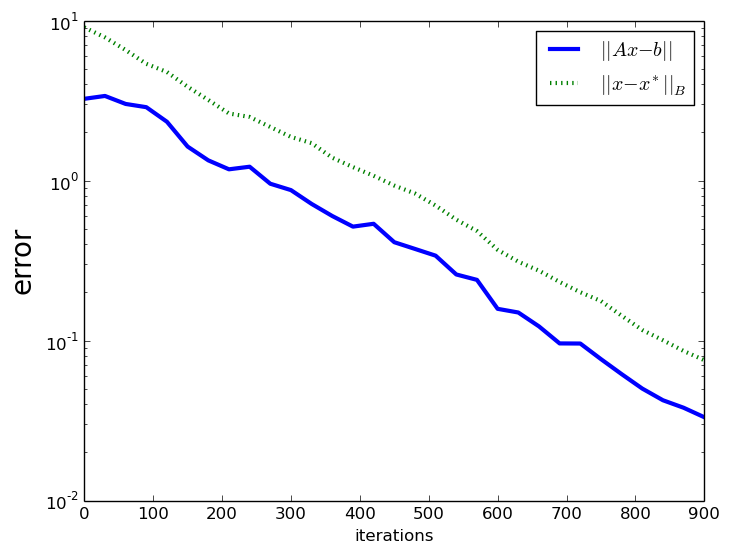

display_figs (generic function with 1 method)

In [7]:
x = zeros(n)  # initial iterate
#x = c

Binv = eye(n) # matrix B is one of the 2 parameters of the method

T = 100*m       # no of iterations 
skip = round(T/30)    # we shall remember x each "skip" number of iterations

# Now we solve the problem
xs, fv = RandomLinearSolve(x, A, b, Binv, sampling, T, skip)

# Let us now plot the results
B = inv(Binv)
PlotResults(B, x_star, xs, fv)

## 7. Extra output for the consensus problem

In [1]:
x_last = xs[:,size(xs)[2]]
println("average to be found = ", sum(c)/n)
println("vector found = ",x_last+c)
println("error = ", norm(x_last+c-ones(n)*sum(c)/n))

LoadError: xs not defined
while loading In[1], in expression starting on line 1

## Problem A

Code up a dedicated randomized Kaczmarz solver. That is, do it in an efficient way so that one does not need to run the $\verb"iterate"$ function. Clearly, this function is rather inefficient - this is because it is so generic.

## Problem B

Code up a dedicated randomized coordinate descent solver. Test it on a random problem for which $A^T A$ is positive definite. Test the solver for two choices of probabilities: uniform and proportional to squared Euclidean norms of the columns of $A$, as covered in the lecture.

## Problem C

Code up the randomized Newton method. Do this for $S = I_{:C}$, where $C$ is a random subset of $\{1,2,\dots,n\}$ of fixed cardinality $\tau$ chosen uniformly at random. Test the method for various choices of $\tau$. Find a $3\times 3$ matrix $A$ such that running the randomized Newton method with $\tau=2$ is vastly (= as much as you want) better than running it with $\tau=1$.

## Problem D

Code up and test the Gaussian descent variant of the method.

## Problem E

Can you come up with some other interesting sketching matrix $S$ not covered in the lecture? When would you use it? 